# **GaNDLF Tutorial: Classification Task**

In this tutorial, we will be using the Generally Nuanced Deep Learning Framework (GaNDLF) to perform training and inference on a VGG model with PathMNIST, a dataset of colon pathology images. This is a multi-class classification task: there are 9 different types of colon tissue displayed in the pathology images, each represented by its own class.

This tutorial demonstrates how to use GaNDLF with a simple classification task. Some steps that would ordinarily be part of the workflow (e.g. data CSV and config YAML file construction) have already been performed for simplicity; please refer to the GaNDLF documentation (located at https://cbica.github.io/GaNDLF/) for more information regarding replication of these steps.

**Important**: Before continuing with this tutorial, please ensure that you are connected to the GPU by navigating to **Runtime --> Change Runtime Type --> Hardware Accelerator** and verifying that "GPU" is listed as the selected option. If not, it is highly recommended that you switch to it now. Also, if available, select the "High-RAM" option under **Runtime --> Change Runtime Type --> Runtime Shape**. Without this option selected, you may end up running out of RAM during training on a base notebook.

## Lets Get Started

### Importing Data

Let's import MedMNIST data and verify the version number before we move on.

In [1]:
import medmnist

/home/vscode/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Time to load our data! Let's download all MedMNIST datasets to the root directory. In this tutorial, we will only be using the PathMNIST dataset; however, feel free to use any of the other datasets you see being downloaded below to try out GaNDLF for yourself!

In [2]:
!python -m medmnist download

Using downloaded and verified file: /home/vscode/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/vscode/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/vscode/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/vscode/.medmnist/octmnist.npz
Using downloaded and verified file: /home/vscode/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/vscode/.medmnist/retinamnist.npz
Using downloaded and verified file: /home/vscode/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/vscode/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/vscode/.medmnist/tissuemnist.npz
Using downloaded and verified file: /home/vscode/.medmnist/organamnist.npz
Using downloaded and verified file: /home/vscode/.medmnist/organcmnist.npz
Using downloaded and verified file: /home/vscode/.medmnist/organsmnist.npz
Using downloaded and verified file: /home/vscode/.medmnist/organmnist3d.npz
Using downloaded and verified

#### Now, let's save all PathMNIST pathology images within the dataset folder (located inside the medmnist directory) in PNG format for use in training and inference. 

#### If you've already gone through this tutorial and are looking to try using a different MedMNIST dataset, simply change `--flag=pathmnist` to any of the other datasets that were downloaded above—it's as simple as that!

In [9]:
!python -m medmnist save --flag=pathmnist --folder=medmnist/dataset/ --postfix=png

Saving pathmnist train...
100%|███████████████████████████████████| 89996/89996 [00:30<00:00, 2939.97it/s]
Saving pathmnist val...
100%|███████████████████████████████████| 10004/10004 [00:03<00:00, 3006.74it/s]
Saving pathmnist test...
100%|█████████████████████████████████████| 7180/7180 [00:02<00:00, 2952.18it/s]


## Training Files

There are 4 training data files located in the medmnist folder we will be using.

1. [train_path_full.csv](medmnist/dataset/train_path_full.csv) with 90,000 images.
2. [val_path_full.csv](medmnist/dataset/val_path_full.csv) with 10,000 validation images.
3. [test_path_full](medmnist/dataset/test_path_full.csv) with 7200 images.

**Note:** For this tutorial, we will be using the full PathMNIST dataset for training, validation and testing. However, to improve efficiency, you may consider using a fraction of this dataset instead with GaNDLF. If so, you can access the appropriate data CSV files at these links:

*   `train_path_tiny` (4,000 images): https://app.box.com/index.php?rm=box_download_shared_file&shared_name=um4003lkrvyj55jm4a0jz7zsuokb0r8o&file_id=f_991821586980

*   `val_path_tiny` (1,000 images): https://app.box.com/index.php?rm=box_download_shared_file&shared_name=rsmff27sm2z34r5xso1jx8xix7nhfspc&file_id=f_991817441206

*   `test_path_tiny` (500 images): https://app.box.com/index.php?rm=box_download_shared_file&shared_name=22lm0qfzk5luap72mtdpzx5l3ocflopa&file_id=f_991819617152



### The Config File:

For the purposes of this tutorial, we have already constructed a config file for this specific task, but for other tasks and experiments that you may want to run, this file will need to be edited to fit the required specifications of your experiment. However, the overall structure of this file will stay the same regardless of your task, and so you should be able to get by by simply downloading and editing the config.yaml file we're using below for use in your own experiments.

Either way, we highly encourage you to take a look at the structure of this file before proceeding if you intend to use GaNDLF for your own experiments, as it will be the backbone of all tasks you use GaNDLF with in the future.

#### Let's visualize some sample images and their classes from the PathMNIST dataset.

#### Image classes for reference:
**Class 0:** Adipose

**Class 1:** Background

**Class 2:** Debris

**Class 3:** Lymphocytes

**Class 4:** Mucus

**Class 5:** Smooth Muscle

**Class 6:** Normal Colon Mucosa

**Class 7:** Cancer-Associated Stroma

**Class 8:** Colorectal Adenocarcinoma Epithelium

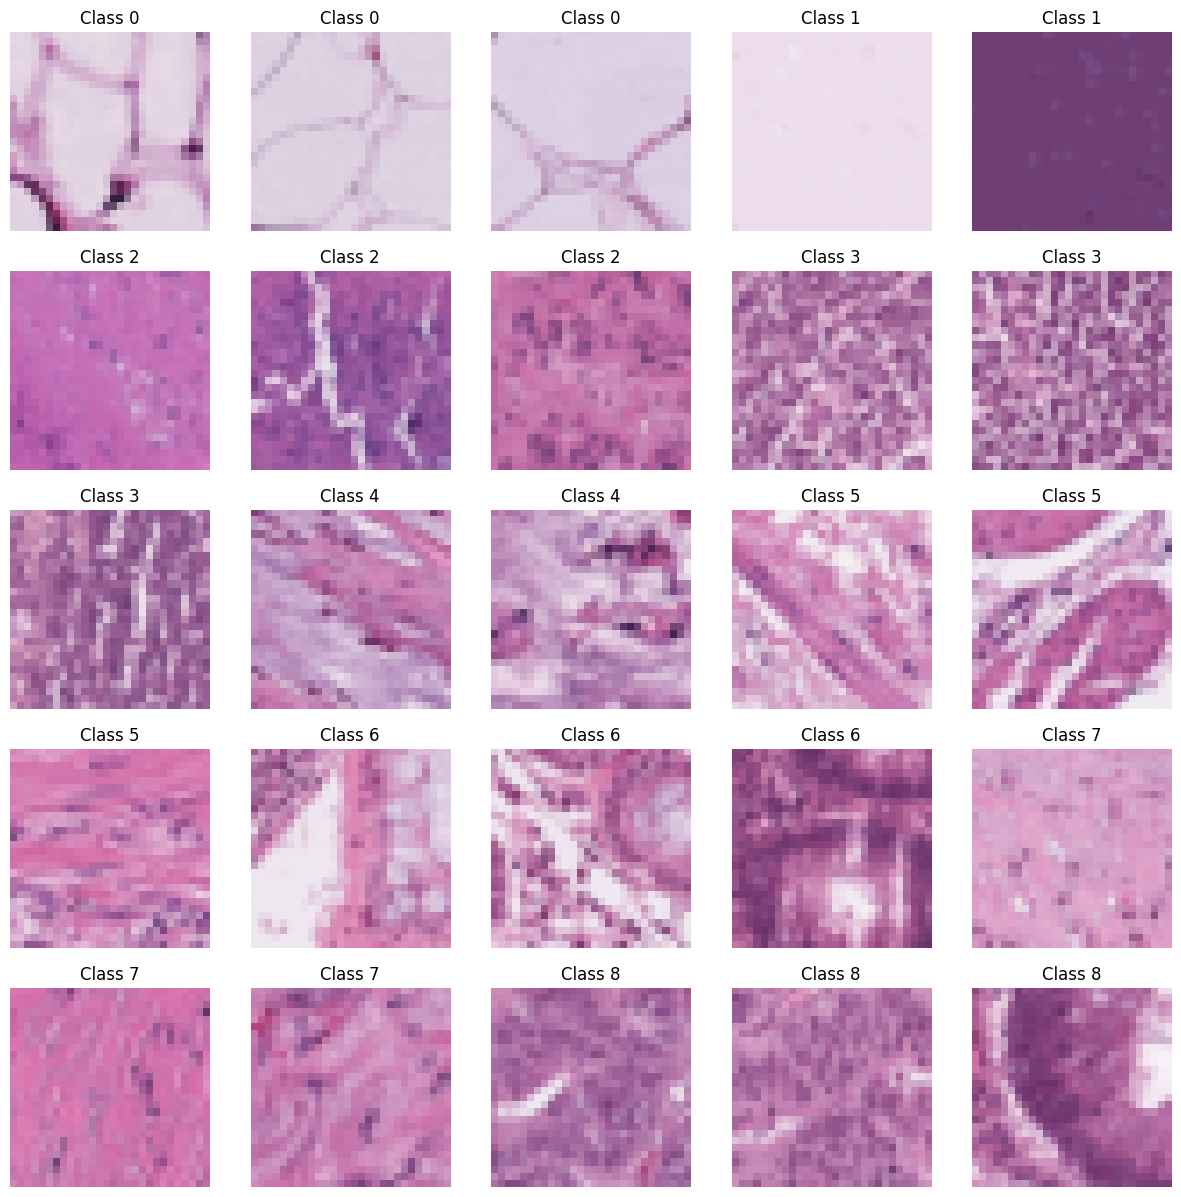

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

df_pathmnist = pd.read_csv('./medmnist/dataset/pathmnist.csv')

selected_images = [32, 36, 46, 13, 14, 8, 12, 18, 5, 6, 17, 0, 16, 3, 7, 10, 43, 45, 55, 1, 31, 41, 4, 9, 11]

fig, ax = plt.subplot_mosaic([
    ['img0', 'img1', 'img2', 'img3', 'img4'],
    ['img5', 'img6', 'img7', 'img8', 'img9'],
    ['img10', 'img11', 'img12', 'img13', 'img14'],
    ['img15', 'img16', 'img17', 'img18', 'img19'],
    ['img20', 'img21', 'img22', 'img23', 'img24']
], figsize=(15, 15))

for i in range(len(selected_images)):
  img = selected_images[i]
  filename = df_pathmnist.iloc[img]['train0_0.png']
  img_class = df_pathmnist.iloc[img]['0']

  path_img = mpimg.imread(f'./medmnist/dataset/pathmnist/{filename}')

  ax[f'img{i}'].imshow(path_img)
  ax[f'img{i}'].axis('off')
  ax[f'img{i}'].set_title(f'Class {img_class}')

plt.show()

#### Now, on to training! Since there is only one GPU, let's set `CUDA_VISIBLE_DEVICES` to 0 to train on the first (and only) available GPU.

In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#### Let's run the training script! For this run, we will pass in the [config.yaml](config.yaml) file that we just downloaded to the `-c` parameter, the training and validation CSV files to the `-i` parameter, and the model directory to the `-m` parameter (folder will automatically be created if it doesn't exist, which, in our case, it doesn't). We will also specify `-t True` to indicate that we are training and `-d cuda` to indicate that we will be training on the GPU. For demonstration purposes, we will only be training on 5 epochs.

#### You will likely notice a persistent error saying "y_pred contains classes not in y_true"--this is a known issue and will not affect our training performance, so feel free to ignore it.

In [16]:
!python ../gandlf_run -c config.yaml -i medmnist/dataset/train_path_full.csv,medmnist/dataset/val_path_full.csv -m model/ -t True -d cuda

The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension
Number of channels :  3
Constructing queue for train data:   0%|              | 0/89996 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/workspaces/GaNDLF/tutorial/../gandlf_run", line 129, in <module>
    main_run(
  File "/workspaces/GaNDLF/GANDLF/cli/main_run.py", line 92, in main_run
    TrainingManager_split(
  File "/workspaces/GaNDLF/GANDLF/training_manager.py", line 341, in TrainingManager_split
    training_loop(
  File "/workspaces/GaNDLF/GANDLF/compute/training_loop.py", line 268, in training_loop
    ) = create_pytorch_objects(params, training_data, validation_data, device)
  File "/workspaces/GaNDLF/GANDLF/compute/generic.py", line 47, in create_pytorch_objects
    train_loader = get_train_loader(parameters)
  File "/workspaces/GaNDLF/GANDLF/data/__init__.py", line 20, in get_train_loader
 

#### Now that training is complete, let's collect and save model statistics to the `output_stats` folder. Using `-c True` indicates that we'd like the 4 plots ordinarily generated by this command to be combined into two plots by overlaying training and validation statistics on the same graphs instead of keeping them separate. Feel free to experiment with this command by using `-c False` instead and viewing the resulting plots.

In [17]:
!python gandlf_collectStats_final -m model/ -o output_stats -c True

#### Now, let's view our generated plots!

In [19]:
from IPython.display import Image
Image("tutorial/output_stats/plot.png", width=1500, height=1000)

FileNotFoundError: No such file or directory: 'tutorial/output_stats/plot.png'

FileNotFoundError: No such file or directory: 'tutorial/output_stats/plot.png'

<IPython.core.display.Image object>

#### Since we only trained the model on a very small number of epochs, we shouldn't be expecting very impressive results here. However, from the graphs, we can tell that accuracy is steadily increasing and loss is steadily decreasing, which is a great sign.

#### Finally, let's run the inference script. This is almost identical to running the training script; however, note that the argument for the `-t` parameter has been changed from `True` to `False` to specify that we are not training, and we are using the `test_path_full` csv file to access the testing images.

In [18]:
!python ../gandlf_run -c config.yaml -i medmnist/dataset/test_path_full.csv -m model/ -t False -d cuda

The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension
Output directory not provided, creating a new directory with a unique timestamp:  model/20230415_013322
Current model type :  torch
Number of dims     :  2
Number of channels :  3
Number of classes  :  9
Device requested via CUDA_VISIBLE_DEVICES:  0
Total number of CUDA devices:  1
Device finally used:  0
Sending model to aforementioned device
Memory Total :  15.8 GB, Allocated:  0.1 GB, Cached:  0.1 GB
Device - Current: 0 Count: 1 Name: Tesla V100-PCIE-16GB Availability: True
Traceback (most recent call last):
  File "/workspaces/GaNDLF/tutorial/../gandlf_run", line 129, in <module>
    main_run(
  File "/workspaces/GaNDLF/GANDLF/cli/main_run.py", line 118, in main_run
    InferenceManager(
  File "/workspaces/GaNDLF/GANDLF/inference_manager.py", line 76, in InferenceManager
    inference_loop(
  File "/workspaces

#### Now that inference is complete, let's view some sample test images along with their predicted and ground truth classes to get a visual idea of how well our model did on each class.

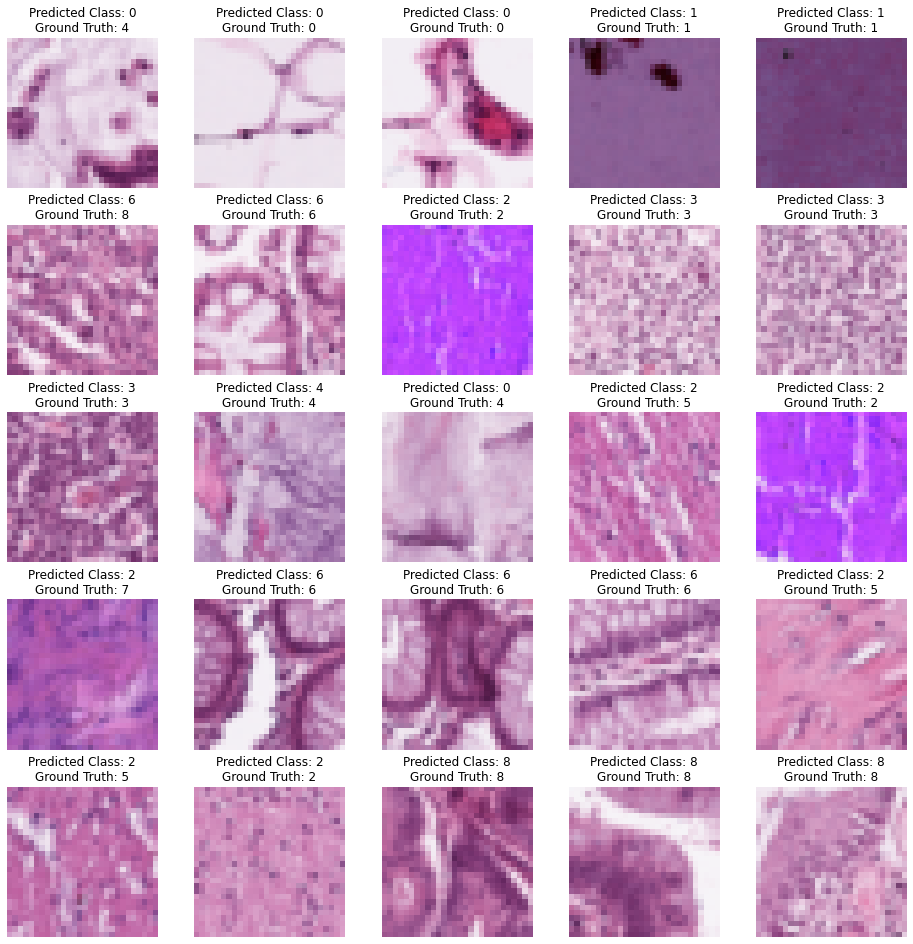

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

df_preds = pd.read_csv('./model/final_preds_and_avg_probs.csv')

selected_images = [4, 7, 14, 22, 26, 3, 11, 17, 37, 45, 52, 1, 2, 40, 47, 76, 8, 13, 28, 19, 36, 79, 0, 9, 10]

fig, ax = plt.subplot_mosaic([
    ['img0', 'img1', 'img2', 'img3', 'img4'],
    ['img5', 'img6', 'img7', 'img8', 'img9'],
    ['img10', 'img11', 'img12', 'img13', 'img14'],
    ['img15', 'img16', 'img17', 'img18', 'img19'],
    ['img20', 'img21', 'img22', 'img23', 'img24']
], figsize=(13, 13), constrained_layout = True)

for i in range(len(selected_images)):
  img = selected_images[i]
  filename = df_preds.iloc[img]['SubjectID']
  ground_truth = filename.split('_')[1].split('.')[0]
  pred_class = df_preds.iloc[img]['PredictedClass']

  path_img = mpimg.imread(f'./medmnist/dataset/pathmnist/{filename}')

  ax[f'img{i}'].imshow(path_img)
  ax[f'img{i}'].axis('off')
  ax[f'img{i}'].set_title(f'Predicted Class: {pred_class}\nGround Truth: {ground_truth}')

plt.show()

#### To conclude this tutorial, let's zoom out and take a look at how well our model did as a whole on each class by constructing a confusion matrix from our inference data.

#### Note: if you'd like, feel free to change the colormap of the confusion matrix (denoted by "cmap" in the cm_display.plot() command) to your liking. Here's a list of some of the most popular colormaps: `viridis` (default), `plasma`, `inferno`, `magma`, `cividis`.

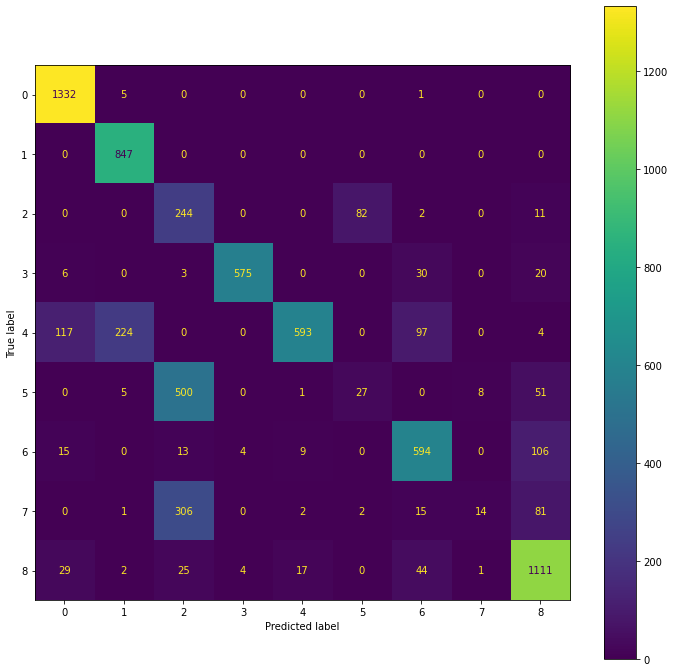

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

gt_list = []
pred_list = []

for i in range(len(df_preds)):
  filename = df_preds.iloc[i]['SubjectID']

  ground_truth = int(filename.split('_')[1].split('.')[0])
  pred_class = int(df_preds.iloc[i]['PredictedClass'])

  gt_list.append(ground_truth)
  pred_list.append(pred_class)

cm = confusion_matrix(gt_list, pred_list)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)

fig, ax = plt.subplots(figsize = (12, 12))
cm_display.plot(cmap = 'viridis', ax = ax)
plt.show()

#### Here, we can see that while the model performed well overall, it had difficulties when it came to images of Class 7, incorrectly predicting a majority of them as belonging to Class 2 instead. We can see a similar trend with images of Class 5, with the model incorrectly predicting most of them as belonging to Class 2. 

#### Given the appearance of the accuracy and loss plots, had we trained on more epochs, we would have expected these results to improve. However, given that we only trained on 5 epochs, these are great results. Indeed, the model did very well on other classes, including Classes 0 and 1.

### That concludes this GaNDLF tutorial! Hopefully, this tutorial was helpful to you in understanding how GaNDLF works as well as how to apply it to your own projects. If you need any additional information about GaNDLF's usage and capabilities, please consult the GitHub repo (https://github.com/CBICA/GaNDLF) and the documentation (https://cbica.github.io/GaNDLF/). For more questions and support, please visit the Discussions page on GitHub (https://github.com/CBICA/GaNDLF/discussions).